In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
directory = '/teamspace/studios/this_studio/time-series-anomaly-detection'
if os.path.exists(directory):
    os.chdir(directory)

from data.dataset_utils import load_data, preprocess, Subjects, prepare_data, get_dataloader
from _3_autoencoder.plot import plot_losses_and_auc, plot_histogram
from _3_autoencoder.test import report, leave_one_subject_out_CV
from _3_autoencoder.models.polyfit import PolyFit

# EDA Baseline

In [2]:
df = load_data(filtered=True)
df = preprocess(df, emg_envelope=True, resample_length=2816)

In [3]:
batch_size = 64
signals = ['gsr']
mp_filter = 0.50

# for training
train_data_normal, _ = prepare_data(df, signals, classes=[0], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
train_loader_normal = get_dataloader(train_data_normal, batch_size=batch_size, shuffle=True)

# for validation
_, test_data = prepare_data(df, signals, classes=[0, 4], train_subjects=Subjects.train, test_subjects=Subjects.val, mp_filter=mp_filter)
test_loader = get_dataloader(test_data, batch_size=batch_size, shuffle=False)

# for testing with training data
_, val_train_data = prepare_data(df, train_subjects=Subjects.val, test_subjects=Subjects.all, signals=signals, classes=[0, 4], mp_filter=mp_filter)
val_train_loader = get_dataloader(val_train_data, batch_size=batch_size, shuffle=False)

Epoch 1/9 - Train loss: 0.8657 - Val loss normal: 0.6391 - Val loss anomaly: 0.6350 - Val AUC: 0.1471
Epoch 2/9 - Train loss: 0.5704 - Val loss normal: 0.4073 - Val loss anomaly: 0.4033 - Val AUC: 0.1521
Epoch 3/9 - Train loss: 0.3588 - Val loss normal: 0.2512 - Val loss anomaly: 0.2505 - Val AUC: 0.1662
Epoch 4/9 - Train loss: 0.2220 - Val loss normal: 0.1578 - Val loss anomaly: 0.1623 - Val AUC: 0.2310
Epoch 5/9 - Train loss: 0.1437 - Val loss normal: 0.1088 - Val loss anomaly: 0.1187 - Val AUC: 0.4859
Epoch 6/9 - Train loss: 0.1042 - Val loss normal: 0.0854 - Val loss anomaly: 0.0999 - Val AUC: 0.6842
Epoch 7/9 - Train loss: 0.0852 - Val loss normal: 0.0741 - Val loss anomaly: 0.0916 - Val AUC: 0.8373
Epoch 8/9 - Train loss: 0.0751 - Val loss normal: 0.0671 - Val loss anomaly: 0.0861 - Val AUC: 0.8839
Epoch 9/9 - Train loss: 0.0679 - Val loss normal: 0.0611 - Val loss anomaly: 0.0803 - Val AUC: 0.8895


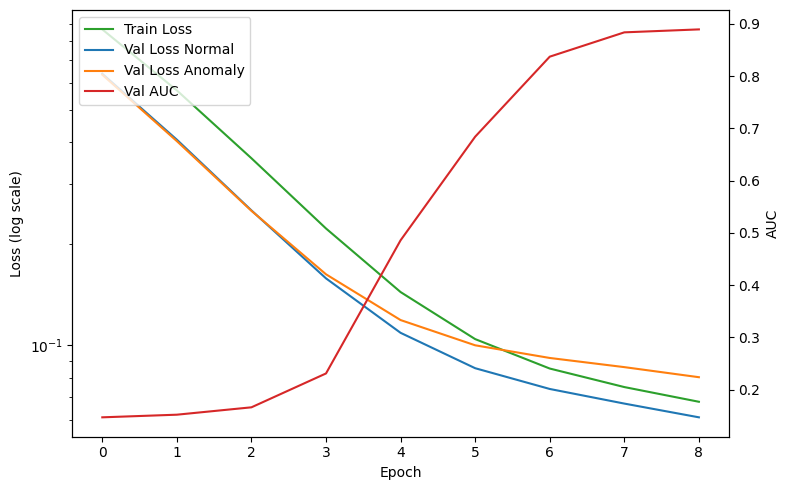

Best AUC: 0.8895 at epoch 9


In [ ]:
config = {'lr': 0.01, 'epochs': 9, 'crop_size': 1000, 'crop_begin': True}

model = PolyFit(config)
train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores, evaluation = model.train_model(train_loader_normal, val_loader=test_loader)
plot_losses_and_auc(train_losses, val_losses_normal, val_losses_anomaly, val_auc_scores)

In [ ]:
evals_train = model.evaluate_model(val_train_loader)
report([evaluation], [evals_train], percentile=80)

method       acc           prec            rec  \
                              NaN       avg  std       avg  std       avg   
0   test_supervised_acc_threshold  0.825000  0.0  0.828794  0.0  0.819231   
1  train_supervised_acc_threshold  0.825000  0.0  0.830078  0.0  0.817308   
2      fixed_percentile_threshold  0.825000  0.0  0.830078  0.0  0.817308   
3                mixmod_threshold  0.511538  0.0  1.000000  0.0  0.023077   
4                filter_threshold  0.511538  0.0  1.000000  0.0  0.023077   
5                 karch_threshold  0.511538  0.0  1.000000  0.0  0.023077   
6                    eb_threshold  0.507692  0.0  1.000000  0.0  0.015385   

             auc      threshold      percentile       
   std       avg  std       avg  std        avg  std  
0  0.0  0.889538  0.0  0.064903  0.0  82.115385  0.0  
1  0.0  0.889538  0.0  0.064907  0.0  79.942529  0.0  
2  0.0  0.889538  0.0  0.064907  0.0        NaN  NaN  
3  0.0  0.889538  0.0  0.217858  0.0        NaN  NaN  
4  0.0  0.889538  0.0  0.240877  0.0        NaN  NaN  
5  0.0  0.889538  0.0  0.236670  0.0        NaN  NaN  
6  0.0  0.889538  0.0  0.331292  0.0        NaN  NaN

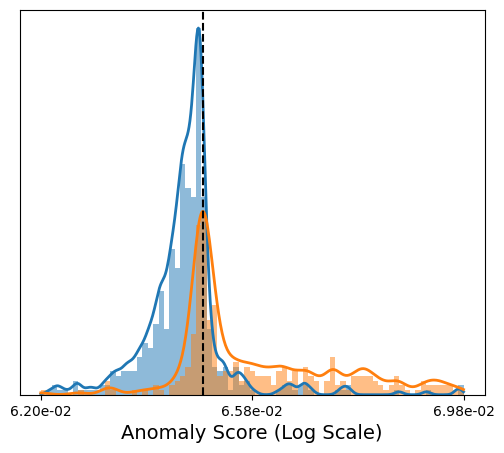

In [ ]:
y_true = evaluation['y_true']
y_scores = evaluation['y_scores']
plot_histogram(y_true, y_scores, mask=(0.062, 0.07), threshold=0.064903)

torch.Size([1, 2816, 1])
Ground truth: 1
Reconstruction error: 0.08551553636789322


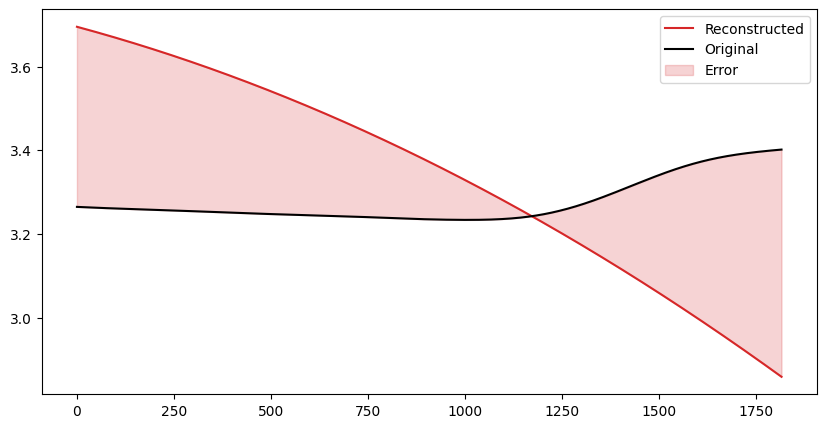

In [21]:
loader = get_dataloader(test_data, batch_size=1, shuffle=True)
signals, labels = next(iter(loader))
print(signals.shape)
print(f'Ground truth: {int(labels[0].item())}')
model.plot_reconstruction(signals, index=0)

## Leave One Subject Out Cross Validation

In [ ]:
config = {'lr': 0.01, 'epochs': 12, 'crop_size': 1000, 'crop_begin': True, 'batch_size': 64, 'mp_filter': 0.5}
evals_test, evals_train = leave_one_subject_out_CV(model=Baseline, config=config, signals=['gsr'], batch_size=config['batch_size'], mp_filter=config['mp_filter'])

In [ ]:
report(evals_test, evals_train, percentile=79)

method       acc                prec            \
                              NaN       avg       std       avg       std   
0   test_supervised_acc_threshold  0.874713  0.121443  0.891248  0.121078   
1  train_supervised_acc_threshold  0.806609  0.125971  0.799840  0.124646   
2      fixed_percentile_threshold  0.804885  0.128085  0.801579  0.126827   
3                mixmod_threshold  0.522989  0.075451  0.126437  0.332341   
4                filter_threshold  0.516667  0.065617  0.114943  0.318953   
5                 karch_threshold  0.517529  0.065884  0.126437  0.332341   
6                    eb_threshold  0.506609  0.041255  0.057471  0.232741   

        rec                 auc           threshold           percentile  \
        avg       std       avg       std       avg       std        avg   
0  0.862069  0.168660  0.879224  0.136747  0.028064  0.006485  83.448276   
1  0.829885  0.220691  0.879224  0.136747  0.025546  0.000017  78.461641   
2  0.821839  0.233379  0.879224  0.136747  0.025553  0.000017        NaN   
3  0.045977  0.150901  0.879224  0.136747  0.141157  0.004248        NaN   
4  0.033333  0.131233  0.879224  0.136747  0.180823  0.004488        NaN   
5  0.035057  0.131768  0.879224  0.136747  0.170001  0.004224        NaN   
6  0.013218  0.082511  0.879224  0.136747  0.335551  0.006967        NaN   

              
         std  
0  14.209240  
1   0.231185  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6        NaN